In [1]:
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
# **Step1.数据准备**
# 噪声维度
z_dim = 100
# 读取真实图片的数据集，这里去除了数据集中的label数据，因为label在这里使用不上，这里不考虑标签分类问题。
def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

# 噪声生成，通过由噪声来生成假的图片数据输入。

def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')

# 生成真实图片reader

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 30000), batch_size=128)

# 生成假图片的reader
z_generator = paddle.batch(z_reader, batch_size=128)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: 
API "paddle.dataset.mnist.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.vision.datasets.MNIST" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


In [3]:
# 定义生成器

def Generator(y, name="G"):
    with fluid.unique_name.guard(name + "/"):
        # 第一组全连接和BN层
        y = fluid.layers.fc(y, size=1024, act='relu')
        y = fluid.layers.batch_norm(y, act='relu')

        # 第二组全连接和BN层
        y = fluid.layers.fc(y, size=128 * 7 * 7)
        y = fluid.layers.batch_norm(y, act='relu')

        # 进行形状变换
        y = fluid.layers.reshape(y, shape=(-1, 128, 7, 7))

        # 第一组转置卷积运算
        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=64, filter_size=5, padding=2, act='relu')

        # 第二组转置卷积运算
        y = fluid.layers.image_resize(y, scale=2)
        y = fluid.layers.conv2d(y, num_filters=1, filter_size=5, padding=2, act='relu')

    return y

In [4]:
# 判别器 Discriminator

def Discriminator(images, name="D"):
    # 一组卷积层和BN层
    def conv_bn(input, num_filters, filter_size):
        y = fluid.layers.conv2d(input=input,
                                num_filters=num_filters,
                                filter_size=filter_size,
                                stride=1,
                                bias_attr=False)
        
        # 激活函数为leaky ReLU
        y = fluid.layers.batch_norm(y, act="leaky_relu")
        return y

    with fluid.unique_name.guard(name + "/"):
        # 第一组卷积池化
        y = conv_bn(images, num_filters=64, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)

        # 第二组卷积池化
        y = conv_bn(y, num_filters=128, filter_size=3)
        y = fluid.layers.pool2d(y, pool_size=2, pool_stride=2)

        # 全连接输出层
        y = fluid.layers.fc(input=y, size=1024)
        y = fluid.layers.batch_norm(input=y, act='leaky_relu')
        y = fluid.layers.fc(y, size=1)

    return y

In [5]:
# 创建一个程序，功能：判别器D识别生成器G生成的假图片
train_d_fake = fluid.Program()

# 创建一个程序，功能：判别器D识别真实图片
train_d_real = fluid.Program()

# 创建一个程序，功能：生成器G生成符合判别器D的程序
train_g = fluid.Program()

#创建一个程序，功能：共同的一个初始化的程序
startup = fluid.Program()

In [6]:
# 从Program获取prefix开头的参数名字

def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]

In [7]:
paddle.enable_static()

# 训练判别器D识别真实图片
with fluid.program_guard(train_d_real, startup):
    # 创建读取真实数据集图片的data，并且label为1
    real_image = fluid.layers.data('image', shape=[1, 28, 28])
    ones = fluid.layers.fill_constant_batch_size_like(real_image, shape=[-1, 1], dtype='float32', value=1)

    # 判别器D判断真实图片的概率
    p_real = Discriminator(real_image)

    # 获取损失函数
    real_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p_real, ones)
    real_avg_cost = fluid.layers.mean(real_cost)


    # 获取判别器D的参数
    d_params = get_params(train_d_real, "D")


    # 创建优化方法
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4)
    optimizer.minimize(real_avg_cost, parameter_list=d_params)

In [8]:
# 训练判别器D识别生成器G生成的图片为假图片

with fluid.program_guard(train_d_fake, startup):

    # 利用创建假的图片data，并且label为0
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    zeros = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=0)#创建一个张量，用value中提供的常量来初始化张量


    # 判别器D判断假图片的概率
    p_fake = Discriminator(Generator(z))


    # 获取损失函数
    fake_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p_fake, zeros)
    fake_avg_cost = fluid.layers.mean(fake_cost)


    # 获取判别器D的参数
    d_params = get_params(train_d_fake, "D")


    # 创建优化方法
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4)
    optimizer.minimize(fake_avg_cost, parameter_list=d_params)

In [9]:
# 训练生成器G生成符合判别器D标准的假图片

with fluid.program_guard(train_g, startup):
    # 噪声生成图片为真实图片的概率，Label为1
    z = fluid.layers.data(name='z', shape=[z_dim, 1, 1])
    ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)


    # 生成图片
    fake = Generator(z)

    # 克隆预测程序
    infer_program = train_g.clone(for_test=True)

    # 生成符合判别器的假图片
    p = Discriminator(fake)

    # 获取损失函数
    g_cost = fluid.layers.sigmoid_cross_entropy_with_logits(p, ones)
    g_avg_cost = fluid.layers.mean(g_cost)

    # 获取G的参数
    g_params = get_params(train_g, "G")

    # 只训练G
    optimizer = fluid.optimizer.AdamOptimizer(learning_rate=2e-4)
    optimizer.minimize(g_avg_cost, parameter_list=g_params)

In [10]:
# 显示图片，构建一个8*8的图片阵列，把预测的图片打印出来。

def show_image_grid(images, pass_id=None):
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Pass {}".format(pass_id))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(image[0], cmap='Greys_r')

    plt.show()

In [11]:
# 创建解析器

# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)

# 初始化参数
exe.run(startup)

W1206 12:44:13.175848   104 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1206 12:44:13.181975   104 device_context.cc:422] device: 0, cuDNN Version: 7.6.


[]

In [12]:
# 测试噪声数据
test_z = np.array(next(z_generator()))

Pass：0，fake_avg_cost：0.922161, real_avg_cost：0.121391, g_avg_cost：0.590646


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

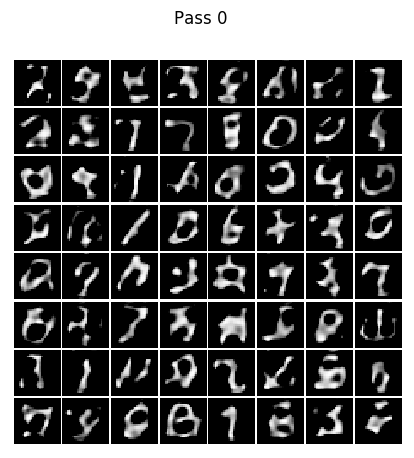

Pass：1，fake_avg_cost：0.875690, real_avg_cost：0.119895, g_avg_cost：0.576817


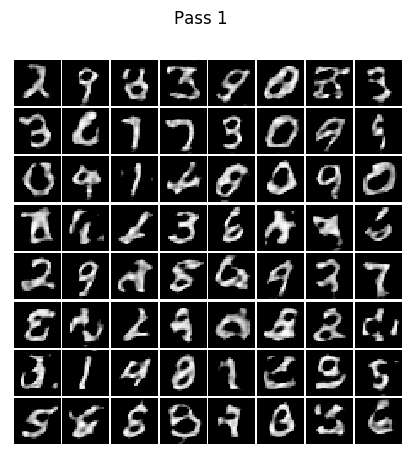

Pass：2，fake_avg_cost：0.858896, real_avg_cost：0.104621, g_avg_cost：0.610633


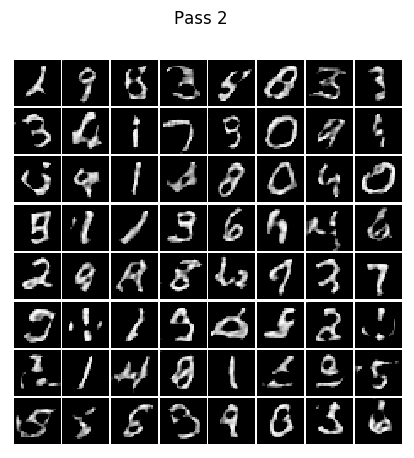

Pass：3，fake_avg_cost：0.832157, real_avg_cost：0.121247, g_avg_cost：0.685011


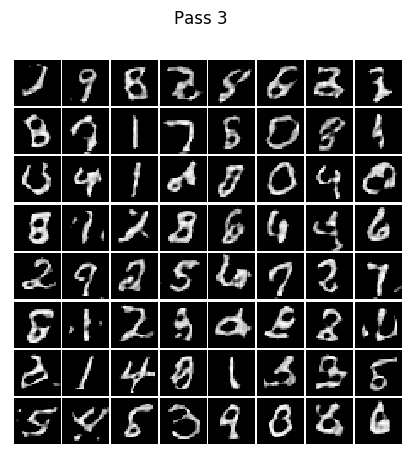

Pass：4，fake_avg_cost：0.828838, real_avg_cost：0.119538, g_avg_cost：0.628978


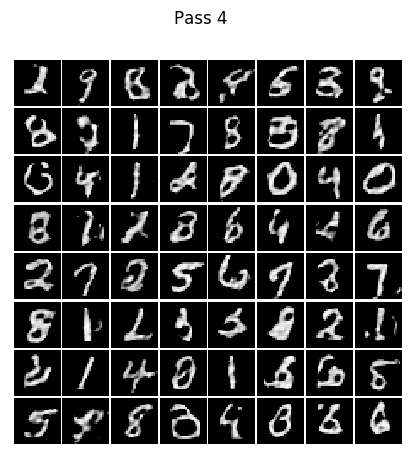

Pass：5，fake_avg_cost：0.809180, real_avg_cost：0.124236, g_avg_cost：0.672625


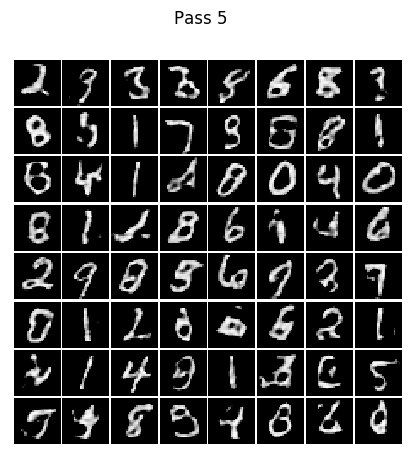

Pass：6，fake_avg_cost：0.815120, real_avg_cost：0.125634, g_avg_cost：0.677010


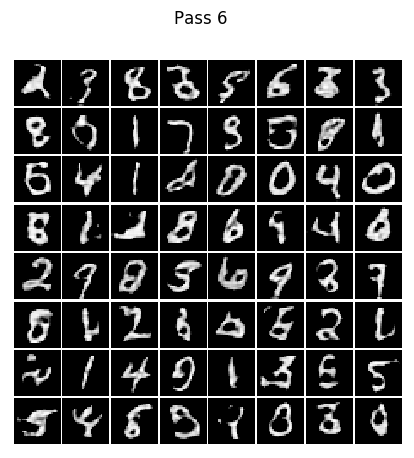

Pass：7，fake_avg_cost：0.479281, real_avg_cost：0.082578, g_avg_cost：1.121967


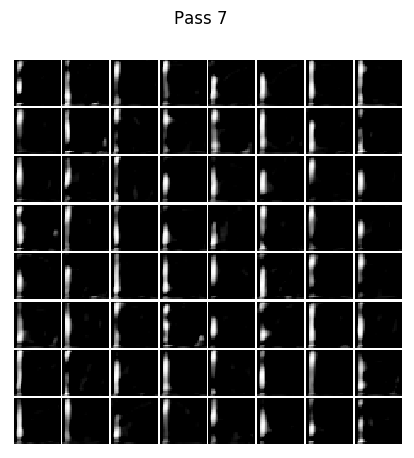

Pass：8，fake_avg_cost：0.276946, real_avg_cost：0.004161, g_avg_cost：1.421039


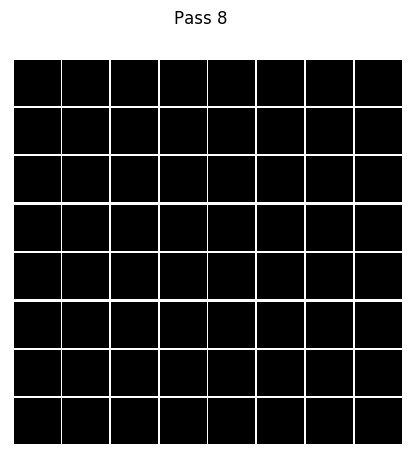

Pass：9，fake_avg_cost：0.111433, real_avg_cost：0.002909, g_avg_cost：2.251183


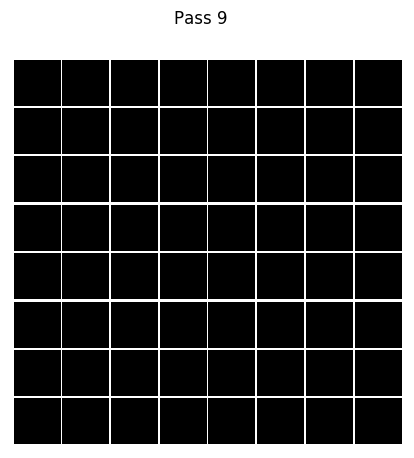

Pass：10，fake_avg_cost：0.054268, real_avg_cost：0.001957, g_avg_cost：2.942151


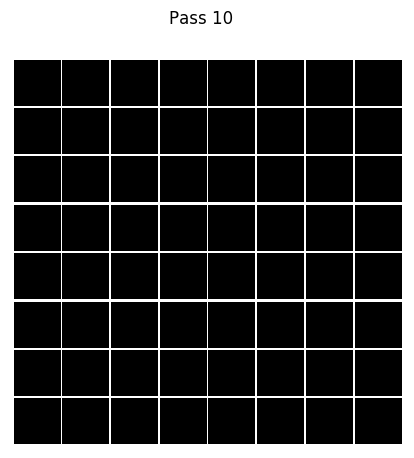

Pass：11，fake_avg_cost：0.030493, real_avg_cost：0.002282, g_avg_cost：3.506475


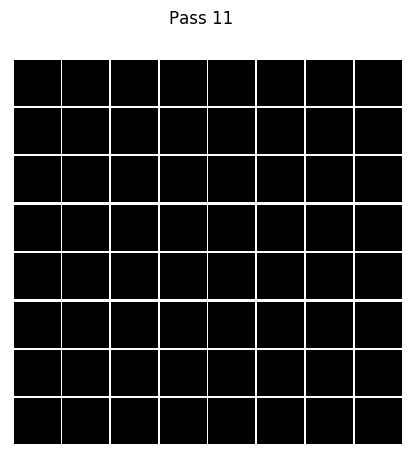

In [13]:
# 开始训练

for pass_id in range(12):
    for i, real_image in enumerate(mnist_generator()):
        # 训练判别器D识别生成器G生成的假图片
        r_fake = exe.run(program=train_d_fake,
                         fetch_list=[fake_avg_cost],
                         feed={'z': np.array(next(z_generator()))})


        # 训练判别器D识别真实图片
        r_real = exe.run(program=train_d_real,
                         fetch_list=[real_avg_cost],
                         feed={'image': np.array(real_image)})


        # 训练生成器G生成符合判别器D标准的假图片

        r_g = exe.run(program=train_g,
                      fetch_list=[g_avg_cost],
                      feed={'z': np.array(next(z_generator()))})

    print("Pass：%d，fake_avg_cost：%f, real_avg_cost：%f, g_avg_cost：%f" % (pass_id, r_fake[0][0], r_real[0][0], r_g[0][0]))


    # 测试生成的图片

    r_i = exe.run(program=infer_program,
                  fetch_list=[fake],
                  feed={'z': test_z})


    # 显示生成的图片

    show_image_grid(r_i[0], pass_id)
